In [1]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import datetime
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import locale

In [2]:
DATA=pathlib.Path.cwd()
df=pd.read_csv(DATA/'datasets'/'online_retail'/'Online Retail.csv')

In [3]:
df[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,"2,55",17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,"3,39",17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,"2,75",17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,"3,39",17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,"3,39",17850.0,United Kingdom


## Preparing the data

Check the information about missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  object 
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Change datatype for 'UnitPrice', its should be 'float'

In [5]:
df['UnitPrice']=df['UnitPrice'].str.replace(',', '.').astype('float')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Displaying descriptive statistics for numerical variables and amount of unique variables for categorical variables.

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
df.select_dtypes(include=['object']).nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
InvoiceDate    23260
Country           38
dtype: int64

There are negative values in 'Quantity', it should be explained by returning of goods, and negative values in 'UnitPrice' its debt repayment.

Rows with negative values in columns 'Quantity' and 'UnitPrice' should be deleted, because these points will be outliers and they will be effect on accuracy of prediction model.

In [9]:
df=df.drop((df[df['Quantity'] < 0].index).union((df[df['UnitPrice']<0].index)))

In [10]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France


Calculating percent of missing values for each columnn.

In [11]:
null_info=pd.DataFrame(data=df.isnull().sum()/df.shape[0]*100, index=df.columns, columns=['null, %'])

In [12]:
null_info

,"null, %"
InvoiceNo,0.000000
StockCode,0.000000
Description,0.111428
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,25.101311
Country,0.000000


Deleting rows with missing values.

In [13]:
df=df.dropna(axis=0)

In [14]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France


Exploring purchase by a 'Country'.

In [15]:
country=pd.DataFrame((df['Country'].value_counts())/df.shape[0]*100).rename(columns={'Country':'Country, %'})

In [16]:
country

,"Country, %"
United Kingdom,89.048411
Germany,2.272293
France,2.096380
EIRE,1.818940
Spain,0.624491
Netherlands,0.593832
Belgium,0.510399
Switzerland,0.462902
Portugal,0.367407
Australia,0.297796


In dataset we left only data from country, that appears most often, because there are not enough data from other countries.

In [17]:
df=df[df['Country']==country.index[0]]

In [18]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,12/9/11 12:31,1.95,15804.0,United Kingdom
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,12/9/11 12:49,2.95,13113.0,United Kingdom
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,12/9/11 12:49,1.25,13113.0,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,12/9/11 12:49,8.95,13113.0,United Kingdom


Converting dates to datetime format for convenient work with data.

In [19]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

In [20]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


Left only dates in 'InvoiceDate'

In [21]:
df['InvoiceDate']=pd.DatetimeIndex(df.InvoiceDate).date

In [22]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09,1.95,15804.0,United Kingdom
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09,2.95,13113.0,United Kingdom
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09,1.25,13113.0,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09,8.95,13113.0,United Kingdom


## RFM

Recency-Frequency-Monetary
    
RFM-analysis allows to segment customers by frequency and cost of purchases and identify those customers who spend the most money. 

Defining the last invoice date - its would be 'today' (NOW) for calculating Recency (time since the last purchase).

In [23]:
NOW=df['InvoiceDate'].max()

In [24]:
NOW

datetime.date(2011, 12, 9)

### Recency

Creating recency dataframe (R_df), which consists of columns CustomerID, Last_Purchase_Date and Recency,   
where
   - Last_Purchase_Date - date of the last purchase of customer,  
   - Recency - time since the last purchase until today.

In [25]:
R_df=pd.DataFrame(df.groupby(['CustomerID'])['InvoiceDate'].max()).rename(columns={'InvoiceDate':'Last_Purchase_Date'})

In [26]:
R_df['Recency']=(NOW-R_df['Last_Purchase_Date']).dt.days

In [27]:
R_df

,Last_Purchase_Date,Recency
CustomerID,,
12346.0,2011-01-18,325
12747.0,2011-12-07,2
12748.0,2011-12-09,0
12749.0,2011-12-06,3
12820.0,2011-12-06,3
...,...,...
18280.0,2011-03-07,277
18281.0,2011-06-12,180
18282.0,2011-12-02,7


In [28]:
R_df.head()

,Last_Purchase_Date,Recency
CustomerID,,
12346.0,2011-01-18,325
12747.0,2011-12-07,2
12748.0,2011-12-09,0
12749.0,2011-12-06,3
12820.0,2011-12-06,3


### Frequency - Monetary

Creating Frequency - Monetary dataframe in variable FM_df.  
Dataframe consist of: 
- CustomerID,
- Frequency - amount of purchases (invoices) for each client,
- Monetary - how much money the customer spent in the store.

In [29]:
FM_df= pd.DataFrame(df.groupby(['CustomerID'])['InvoiceNo'].nunique()).rename(columns={'InvoiceNo':'Frequency'})

In [30]:
price=pd.DataFrame(data= df['UnitPrice']*df['Quantity'], index=df.index, columns=['Price'])

In [31]:
price=pd.concat([price, df['CustomerID']], axis=1)

In [32]:
FM_df['Monetary']=price.groupby(['CustomerID'])['Price'].sum()

In [33]:
FM_df.head()

,Frequency,Monetary
CustomerID,,
12346.0,1,77183.60
12747.0,11,4196.01
12748.0,210,33719.73
12749.0,5,4090.88
12820.0,4,942.34


### RFM
Creating RFM_df, which consist of R_df and FM_df.

In [34]:
RFM_df=pd.concat([R_df,FM_df], axis=1)

In [35]:
RFM_df

,Last_Purchase_Date,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,2011-01-18,325,1,77183.60
12747.0,2011-12-07,2,11,4196.01
12748.0,2011-12-09,0,210,33719.73
12749.0,2011-12-06,3,5,4090.88
12820.0,2011-12-06,3,4,942.34
...,...,...,...,...
18280.0,2011-03-07,277,1,180.60
18281.0,2011-06-12,180,1,80.82
18282.0,2011-12-02,7,2,178.05


## K-means for RFM segmentation

K-means gives the best results in case of:
- Data distribution is not skewed (no long tails)
- Data are standardized.

Creating data distribution diagrams for Recency, Frequency and Monetary in RFM_df and check skewness for each of the columns.

1.2453372998836876

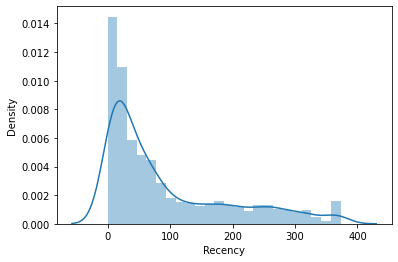

In [36]:
sns.distplot(RFM_df['Recency']);
RFM_df['Recency'].skew()

10.806240485679126

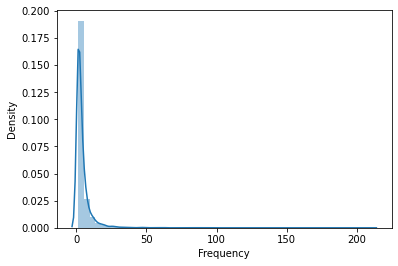

In [37]:
sns.distplot(RFM_df['Frequency']);
RFM_df['Frequency'].skew()

20.200739754134936

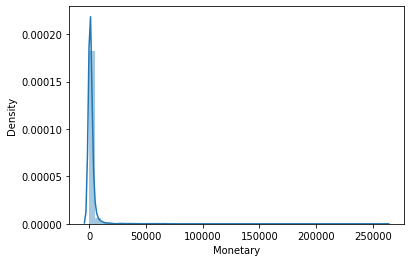

In [38]:
sns.distplot(RFM_df['Monetary']);
RFM_df['Monetary'].skew()

The data is highly skewed, so we will perform log transformations on it to reduce the skewness of each variable.
On each of the variables 'Recency','Frequency','Monetary', perform a log(x+1) transformation.
We add a constant because the log conversion requires all values to be positive.

In [39]:
RFM_df_log=RFM_df.copy(deep=True)

In [40]:
RFM_df_log['Frequency']=np.log(RFM_df_log['Frequency']+1)

In [41]:
RFM_df_log['Monetary']=np.log(RFM_df_log['Monetary']+1)

In [42]:
RFM_df_log['Recency']=np.log(RFM_df_log['Recency']+1)

-0.4632066231049212

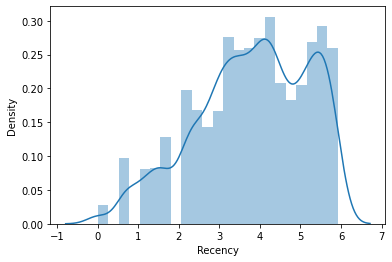

In [43]:
sns.distplot(RFM_df_log['Recency']);
RFM_df_log['Recency'].skew()

1.1823613711968488

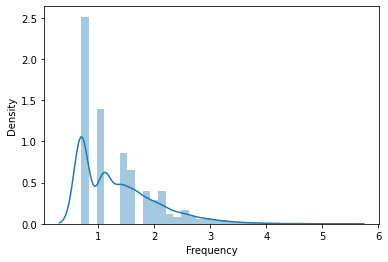

In [44]:
sns.distplot(RFM_df_log['Frequency']);
RFM_df_log['Frequency'].skew()

0.33290669935158396

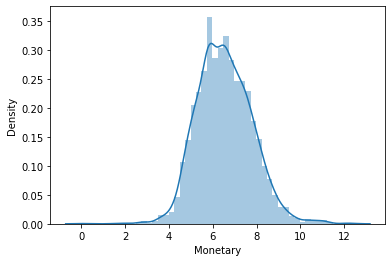

In [45]:
sns.distplot(RFM_df_log['Monetary']);
RFM_df_log['Monetary'].skew()

After all the transformations we still have 'tails'. I will use Winsorizing techique and 'feature_engine' library to remove it.

In [46]:
windsoriser = Winsorizer(tail='both', fold=2, variables=['Recency','Frequency', 'Monetary'])

In [47]:
windsoriser.fit(RFM_df_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [48]:
RFM_df_log= windsoriser.transform(RFM_df_log)

In [49]:
RFM_df_log=RFM_df_log.drop(['Last_Purchase_Date'], axis=1)

In [50]:
RFM_df_log.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.786897,0.693147,9.040271
12747.0,1.098612,2.484907,8.342128
12748.0,1.033919,2.710845,9.040271
12749.0,1.386294,1.791759,8.316760
12820.0,1.386294,1.609438,6.849427


-0.34794948149122745

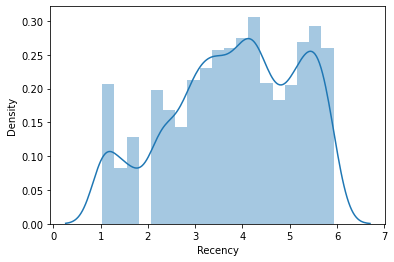

In [51]:
sns.distplot(RFM_df_log['Recency']);
RFM_df_log['Recency'].skew()

0.720494876963109

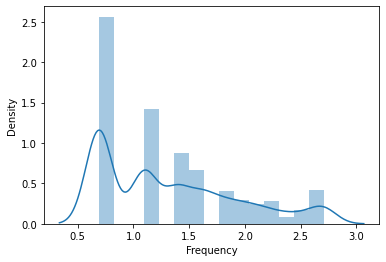

In [52]:
sns.distplot(RFM_df_log['Frequency']);
RFM_df_log['Frequency'].skew()

0.1615711640365458

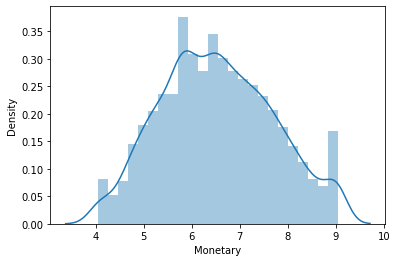

In [53]:
sns.distplot(RFM_df_log['Monetary']);
RFM_df_log['Monetary'].skew()

Standardizing RFM variables with StandardScaler.

In [54]:
scaler=StandardScaler()

In [55]:
RFM_df_scaled=scaler.fit_transform(RFM_df_log[['Recency', 'Frequency', 'Monetary']])

In [56]:
RFM_df_scaled=pd.DataFrame(RFM_df_scaled, columns=['Recency', 'Frequency', 'Monetary'])

In [57]:
RFM_df_scaled=RFM_df_scaled.set_index(RFM_df_log.index)

In [58]:
RFM_df_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,1.465561,-1.016505,2.148546
12747.0,-2.017775,1.868943,1.550754
12748.0,-2.065841,2.232794,2.148546
12749.0,-1.804030,0.752699,1.529032
12820.0,-1.804030,0.459089,0.272614


Defining optimal amounts of clusters using Elbow Method.
Plotting the values of the sum of intracluster distances for different values of K.

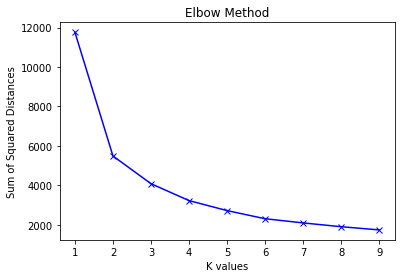

In [59]:
K = range(1,10)
sum_of_squared_distances = []

for k in K:
    model = KMeans(n_clusters=k).fit(RFM_df_scaled)
    sum_of_squared_distances.append(model.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('K values')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt;

As can be seen from the plot optimal value of clusters could be in range from 3 to 5, when the value of inertia (sum of intracluster distances) becomes constant.

## Defining the optimal number of clusters

In [60]:
original_df_rfm=RFM_df[['Recency', 'Frequency', 'Monetary']]

In [61]:
original_df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,11,4196.01
12748.0,0,210,33719.73
12749.0,3,5,4090.88
12820.0,3,4,942.34


In [62]:
from sklearn.manifold import TSNE

def fit_visualize_kmeans(RFM_df_scaled, clusters_number, original_df_rfm):

    model_kmeans = KMeans(n_clusters=clusters_number).fit(RFM_df_scaled)

    cluster_labels = model_kmeans.labels_
        
    # Copy original_df_rfm and add column with cluster numbers
    df_new = original_df_rfm.copy()
    df_new['Cluster'] = cluster_labels
    
    # Initializing TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Visualization of TSNE transformation
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    params = dict(
        x=transformed[:,0], 
        y=transformed[:,1],
        hue=cluster_labels, 
        style=cluster_labels, 
        palette="Set1"
    )
    sns.scatterplot(**params)
    return df_new

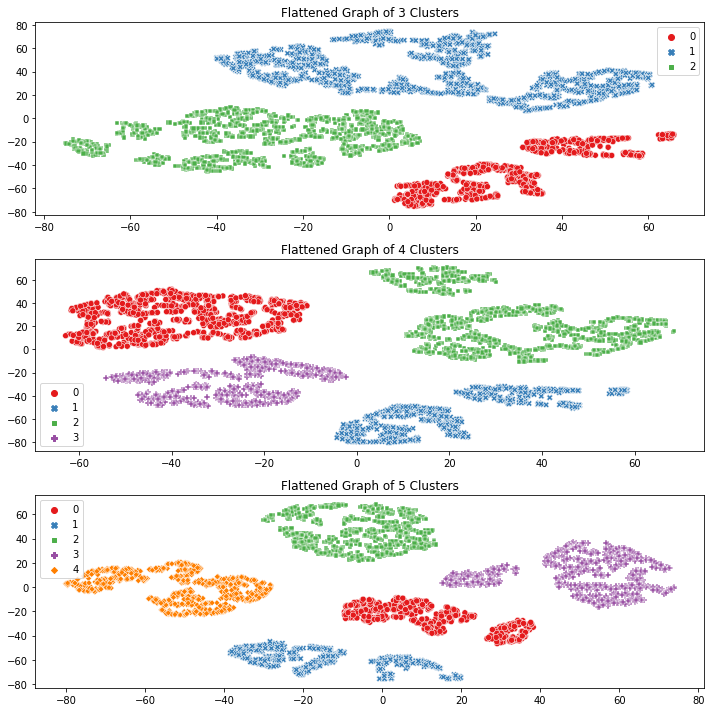

In [63]:
plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
df_rfm_k3 = fit_visualize_kmeans(RFM_df_scaled, clusters_number=3, original_df_rfm=RFM_df_log)

plt.subplot(3, 1, 2)
df_rfm_k4 = fit_visualize_kmeans(RFM_df_scaled, clusters_number=4, original_df_rfm=RFM_df_log)

plt.subplot(3, 1, 3)
df_rfm_k5 = fit_visualize_kmeans(RFM_df_scaled, clusters_number=5, original_df_rfm=RFM_df_log)

plt.tight_layout()

## Visualization with Snake plots

In [64]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans):
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']

    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.lineplot('Metric', 'Value', hue='Cluster', data=df_melt)

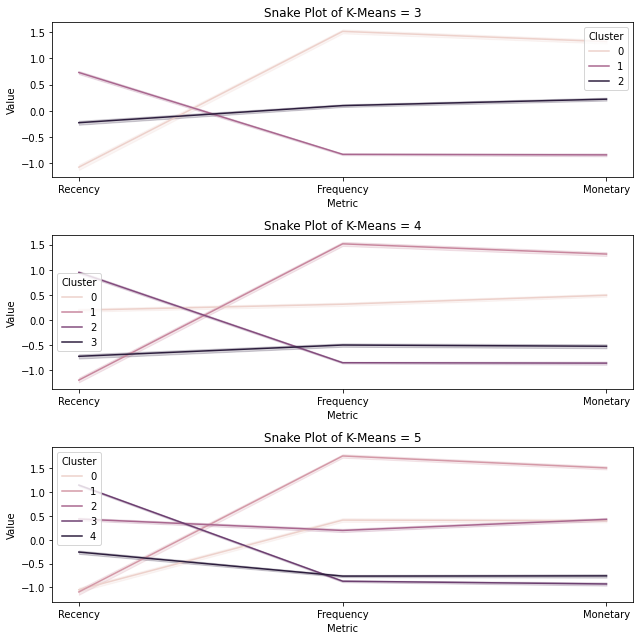

In [65]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
plt.title('Snake Plot of K-Means = 3')
snake_plot(RFM_df_scaled, df_rfm_k3)

plt.subplot(3, 1, 2)
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_df_scaled, df_rfm_k4)

plt.subplot(3, 1, 3)
plt.title('Snake Plot of K-Means = 5')
snake_plot(RFM_df_scaled, df_rfm_k5)

plt.tight_layout()

As can be seen from plots the best segmentation of customers with clusters number=4.

Creating table with RFM information about each of clusters and amount of customers in each cluster.

In [66]:
RFM_df['Cluster']=df_rfm_k4.Cluster.to_list()

In [67]:
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }).round(0)
    
    return df_new

In [68]:
rfm_values(RFM_df)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          76.0       4.0   1572.0  1047
1          13.0      12.0   6318.0   775
2         190.0       1.0    312.0  1334
3          21.0       2.0    457.0   765

Cluster 1 looks like it consists of customers that make purchases with a low frequency, but give a significant monetary. Probably these are regular customers and we can make some special offers for these customers to increase frequency of purchases. Cluster 2 consists of customers that give the biggest monetary and make purchase frequently. Cluster 3 is the biggest cluster wich consists of customers that mostly make just 1 purchase and give the smallest monetary. Cluster 4 probably could consists of new clients because of low values of Frequency and Recency, so we can make some offers to these customers to stimulate them to make more purchases and still choose our shop.